In [ ]:
from numpy import array
from sklearn.model_selection import KFold
import pandas as pd

import numpy as np
import random
import matplotlib.pyplot as plt
from numpy.random import default_rng

from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from datetime import datetime
import tensorflow as tf

from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools

from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL

from sklearn.model_selection import train_test_split
from hyperopt.pyll.base import scope

from sklearn.utils import class_weight

# Simulated Datasets (Multiclass Classification) Generation
- Normal distribution dataset
  - Data d (cluster_std=1), Data e (cluster_std=2), Data f (cluster_std=3)
- moon shape dataset
  - Data g (sigma=0.1), Data h (sigma=0.2), Data i (sigma=0.4)
- circle shape dataset  
  - Data m (factor=0.1, noise=0.6), Data n (factor=0.3, noise=0.7), Data o (factor=0.5, noise=0.8)

In [ ]:
def normal_distribution_data(n_samples,n_classes,cluster):
    colors = ['purple', 'yellow','green'] # Provide possible maximum number of classes
    vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    features, true_labels = make_blobs(n_samples=n_samples, n_features=2, centers=n_classes, cluster_std=cluster, random_state=45)
    d = {'x1': features[:,0], 'x2': features[:,1], 'label': true_labels}
    two_cl_data = pd.DataFrame(data=d)
    X_all = two_cl_data[['x1','x2']]
    y_all = two_cl_data['label']
    return(X_all,y_all)


def moon_shape(number_of_moons,sigma, radius, number_of_datapoints,y_shift):
    moons = []
    np.random.seed(45)
    for y in range(number_of_moons):
        q = np.random.uniform(0,np.pi,size=number_of_datapoints)
        if y % 2 == 0:
            factor = 1
        else:
            factor = -1
        moon = np.zeros((number_of_datapoints, 3))
        moon[:,0] = (radius * np.cos(q)) + y
        moon[:,1] = (radius * np.sin(q) * factor) + (factor == -1) * y_shift
        moon[:,2] = y
        moons.append(moon)
        noise = np.random.normal(0, sigma, size=moon[:,:2].shape)
        moon[:,:2] += noise
    moons = np.concatenate(moons)
    d = {'x1': moons[:,0], 'x2': moons[:,1], 'label': moons[:,2]}
    data = pd.DataFrame(data=d)
    X_all = data[['x1','x2']]
    y_all = data['label']
    return(X_all,y_all)


def three_circle_shape(f1,f2):
    X_small, y_small = make_circles(n_samples=(2000,4000), random_state=3, noise=0.06, factor = f1)
    X_large, y_large = make_circles(n_samples=(2000,4000), random_state=3, noise=0.06, factor = f2)
    y_large[y_large==1] = 2
    df = pd.DataFrame(np.vstack([X_small,X_large]),columns=['x1','x2'])
    df['label'] = np.hstack([y_small,y_large])
    X_all = df[['x1','x2']]
    y_all = df['label']
    return(X_all,y_all)

# Example code of running CDdm with Data f

In [ ]:
# File path
file_name = '(f)three_class_ND.xlsx'

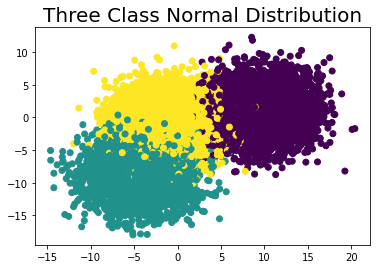

In [ ]:
# Three class normal distribution
three_nd_X,three_nd_y = normal_distribution_data(n_samples=12000,n_classes=3,cluster=3)
plt.scatter(three_nd_X[:,0], three_nd_X[:,1], c=three_nd_y)
plt.title("Three Class Normal Distribution",fontsize=20)
plt.show()

'''
# Circle shape
two_cs_X,two_cs_y = three_circle_shape(0.3,0.7)
'''

'''
# Moon shape
two_ms_X,two_ms_y = moon_shape(number_of_moons=3,sigma=0.1, radius=1, number_of_datapoints=4000,y_shift=0.3)
'''

## Divide data into five sets

In [ ]:
# Split the data to five groups and save each index in fold_indices
kfold = KFold(n_splits=5, shuffle=True, random_state= 0)

# Save the index of each fold in a list
fold_index = []
for train_index, test_index in kfold.split(two_cs_X):
    fold_index.append((test_index))

In [ ]:
# Order of using folds
fold_order = []
lst = [0,1,2,3,4]
for order in range(len(lst)):
    fold_order.append(lst[order:] + lst[:order])
print(fold_order)
print(fold_order[0])

[[0, 1, 2, 3, 4], [1, 2, 3, 4, 0], [2, 3, 4, 0, 1], [3, 4, 0, 1, 2], [4, 0, 1, 2, 3]]
[0, 1, 2, 3, 4]


In [ ]:
# number of neurons and layer combination for Hyperopt
numbers = [5, 10, 15, 20]
one_combinations_with_order = list(itertools.product(numbers))
two_combinations_with_order = list(itertools.product(numbers, repeat=2))
three_combinations = list(itertools.product(numbers, repeat=3))

layer_neuron_orders = []
layer_neuron_orders = one_combinations_with_order + two_combinations_with_order+three_combinations
print(layer_neuron_orders)

[(5,), (10,), (15,), (20,), (5, 5), (5, 10), (5, 15), (5, 20), (10, 5), (10, 10), (10, 15), (10, 20), (15, 5), (15, 10), (15, 15), (15, 20), (20, 5), (20, 10), (20, 15), (20, 20), (5, 5, 5), (5, 5, 10), (5, 5, 15), (5, 5, 20), (5, 10, 5), (5, 10, 10), (5, 10, 15), (5, 10, 20), (5, 15, 5), (5, 15, 10), (5, 15, 15), (5, 15, 20), (5, 20, 5), (5, 20, 10), (5, 20, 15), (5, 20, 20), (10, 5, 5), (10, 5, 10), (10, 5, 15), (10, 5, 20), (10, 10, 5), (10, 10, 10), (10, 10, 15), (10, 10, 20), (10, 15, 5), (10, 15, 10), (10, 15, 15), (10, 15, 20), (10, 20, 5), (10, 20, 10), (10, 20, 15), (10, 20, 20), (15, 5, 5), (15, 5, 10), (15, 5, 15), (15, 5, 20), (15, 10, 5), (15, 10, 10), (15, 10, 15), (15, 10, 20), (15, 15, 5), (15, 15, 10), (15, 15, 15), (15, 15, 20), (15, 20, 5), (15, 20, 10), (15, 20, 15), (15, 20, 20), (20, 5, 5), (20, 5, 10), (20, 5, 15), (20, 5, 20), (20, 10, 5), (20, 10, 10), (20, 10, 15), (20, 10, 20), (20, 15, 5), (20, 15, 10), (20, 15, 15), (20, 15, 20), (20, 20, 5), (20, 20, 10), 

## Generate two neural networks model

In [ ]:
# Neural networks models A
def create_model_multiclass(params):
    # Create model
    #print("params['hidden_layer_sizes']:",params['hidden_layer_sizes'])
    model = tf.keras.models.Sequential()
    # First hidden layer with input shape
    model.add(Dense(params['hidden_layer_sizes'][0], input_shape=(2,), activation=params['activation']))
    for i in range(1,len(params['hidden_layer_sizes'])):
        # from second hidden layer to number of hidden layers
        model.add(Dense(params['hidden_layer_sizes'][i], activation=params['activation']))

    # Ouput layer
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=params['learnRate']), metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=50)
    result = model.fit(train_x_model_A, train_y_model_A, verbose=0, validation_split=0.3, batch_size = params['batch_size'],
                       callbacks=[es], epochs = 500)

    validation_loss = np.amin(result.history['val_loss'])
    print('Best validation loss of epoch:', validation_loss)

    return {'loss': validation_loss,
            'status': STATUS_OK,
            'model': model,
            'params': params}


# Neural networks model B
def create_model_binarayclass(params):
    # Create model
    model = tf.keras.models.Sequential()
    # First hidden layer with input shape
    model.add(Dense(params['hidden_layer_sizes'][0], input_shape=(2,), activation=params['activation']))
    for i in range(1,len(params['hidden_layer_sizes'])):
        # from second hidden layer to number of hidden layers
        model.add(Dense(params['hidden_layer_sizes'][i], activation=params['activation']))

    # Ouput layer
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=params['learnRate']), metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=50)
    result = model.fit(model_B_train_x, model_B_train_y, verbose=0, validation_split=0.3,
                       batch_size = params['batch_size'], epochs = 500,
                       callbacks=[es])

    validation_loss = np.amin(result.history['val_loss'])
    #validation_acc = np.amin(result.history['val_accuracy'])
    print('Best validation loss of epoch:', validation_loss)

    return {'loss': validation_loss,
            'status': STATUS_OK,
            'model': model,
            'params': params}

## CDdm process

In [ ]:
def CDdm(three_nd_X,three_nd_y,folds):
    # First and Second folds
    X_fold = three_nd_X[fold_index[folds[0]]]
    y_fold = three_nd_y[fold_index[folds[0]]]
    d = {'x1': X_fold[:,0], 'x2': X_fold[:,1], 'label': y_fold}
    three_cl_data1 = pd.DataFrame(data=d)

    X_fold = three_nd_X[fold_index[folds[1]]]
    y_fold = three_nd_y[fold_index[folds[1]]]
    d = {'x1': X_fold[:,0], 'x2': X_fold[:,1], 'label': y_fold}
    three_cl_data2 = pd.DataFrame(data=d)

    # train_data_for_model_A is concat of fold 1, fold 2
    train_data_for_model_A = pd.concat([three_cl_data1,three_cl_data2],ignore_index=True)
    # Check the label is balanced
    print(train_data_for_model_A['label'].value_counts())

    global train_x_model_A, train_y_model_A

    # train_data_for_model_A to x,y
    train_x_model_A =  train_data_for_model_A.loc[:,['x1','x2']]
    train_y_model_A =  train_data_for_model_A.loc[:,['label']]
    train_y_model_A = np_utils.to_categorical(train_y_model_A,3)


    # new search space
    search_space = {#'learnRate': hp.uniform('learnRate',0.01,0.1),
                  #'batch_size': scope.int(hp.quniform('batch_size',100,250,25)),
                    'learnRate': hp.choice('learnRate',[0.01,0.03,0.1]),
                    'batch_size': scope.int(hp.choice('batch_size',[32,64,128])),
                    'activation':hp.choice('activation',['relu','tanh']),
                    'hidden_layer_sizes':hp.choice('hidden_layer_sizes',layer_neuron_orders)}

    trials = Trials()
    best = fmin(fn=create_model_multiclass,
                       space=search_space,
                       algo=tpe.suggest,
                       max_evals=5,
                       trials=trials)

    print("best:",best)


    best_model_A = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']
    best_params_A = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']
    print("best_params_A:",best_params_A)

    # Third and Fourth folds
    X_fold = three_nd_X[fold_index[folds[2]]]
    y_fold = three_nd_y[fold_index[folds[2]]]
    d = {'x1': X_fold[:,0], 'x2': X_fold[:,1], 'label': y_fold}
    three_cl_data1 = pd.DataFrame(data=d)

    X_fold = three_nd_X[fold_index[folds[3]]]
    y_fold = three_nd_y[fold_index[folds[3]]]
    d = {'x1': X_fold[:,0], 'x2': X_fold[:,1], 'label': y_fold}
    three_cl_data2 = pd.DataFrame(data=d)

    # test data for model A with fold 3, fold 4
    test_data_for_model_A = pd.concat([three_cl_data1,three_cl_data2],ignore_index=True)
    print(test_data_for_model_A['label'].value_counts())


    # test_data_for_model_A to x and answer
    model_A_X_test = test_data_for_model_A.loc[:,['x1','x2']]
    answer = test_data_for_model_A['label']

    # Traind model A make predictions
    model_A_predictions = np.argmax(best_model_A.predict(model_A_X_test), axis=1)

    # Compare between answer and predictions from model A for fold 3, 4
    id_df = pd.DataFrame()
    id_df["actual"] = answer
    id_df["predicted"] = model_A_predictions
    incorrect = id_df.loc[id_df.actual != id_df.predicted]
    #print("incorrect:",incorrect)

    incorrect_index = []
    incorrect_index = incorrect.index
    print("number of incorrect predictions:",len(incorrect_index))
    sum_number_incorrect.append(len(incorrect_index))

    # Provide 0 to incorrect, 1 to correct
    # Append correctness to the fold 3, 4 dataset and find the hyperparameter
    wrong_number = incorrect_index
    correctness = []
    for i in range(len(model_A_X_test)):
        if model_A_X_test.index[i] in wrong_number:
          correctness.append(0)
        elif model_A_X_test.index[i] not in wrong_number:
          correctness.append(1)
        else:
          print("error")
    correctness = pd.DataFrame(correctness,columns =['correctness'])
    print(correctness['correctness'].value_counts())

    plot = plt.scatter(model_A_X_test['x1'], model_A_X_test['x2'], c=1-correctness['correctness'],cmap='Reds', vmin=0, vmax=1)
    plt.colorbar(plot)
    plt.title("correctness",fontsize=20)
    plt.show()


    global model_B_train_x, model_B_train_y
    # fold 3, 4 data with correctness
    model_B_train_x =  model_A_X_test
    model_B_train_y =  correctness

    trials = Trials()
    best = fmin(fn=create_model_binarayclass,
                       space=search_space,
                       algo=tpe.suggest,
                       max_evals=10,
                       trials=trials)

    print("best:",best)

    best_model_B = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']
    best_params_B = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']
    print("best_params_B:",best_params_B)

    # Predict fold 5 label correctness
    X_fold = three_nd_X[fold_index[folds[4]]]
    y_fold = three_nd_y[fold_index[folds[4]]]
    d = {'x1': X_fold[:,0], 'x2': X_fold[:,1], 'label': y_fold}
    difficulty_data_for_model_B = pd.DataFrame(data=d)


    difficulty_x = difficulty_data_for_model_B.loc[:,['x1','x2']]
    predicted_difficulty = 1 - best_model_B.predict(difficulty_x)
    predicted_difficulty = predicted_difficulty[:,0].tolist()

    plot = plt.scatter(difficulty_data_for_model_B['x1'], difficulty_data_for_model_B['x2'], c=predicted_difficulty,cmap='Reds')
    plt.colorbar(plot)
    plt.title("difficulty",fontsize=20)
    plt.show()

    plot = plt.scatter(difficulty_data_for_model_B['x1'], difficulty_data_for_model_B['x2'], c=predicted_difficulty,cmap='Reds', vmin=0, vmax=1)
    plt.colorbar(plot)
    plt.title("difficulty(0~1)",fontsize=20)
    plt.show()

    return(difficulty_data_for_model_B, predicted_difficulty)

## Repeat the process five times
- to obtain the case difficulties of all sets


fold: [0, 1, 2, 3, 4]
1    1628
0    1591
2    1581
Name: label, dtype: int64
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

2023-02-15 09:32:19.661929: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-02-15 09:32:19.662019: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-15 09:32:19.662094: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cn049): /proc/driver/nvidia/version does not exist
2023-02-15 09:32:19.662404: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 09:32:19.786056: I tensorflow/compiler/mlir/mlir_graph_optimiz

Epoch 00063: early stopping                          
Best validation loss of epoch:                       
0.18014712631702423                                  
Epoch 00062: early stopping                                                     
Best validation loss of epoch:                                                  
0.18576928973197937                                                             
Epoch 00061: early stopping                                                     
Best validation loss of epoch:                                                  
0.18799808621406555                                                             
Epoch 00051: early stopping                                                     
Best validation loss of epoch:                                                  
0.24130424857139587                                                             
Epoch 00061: early stopping                                                     
Best validation loss of epoc

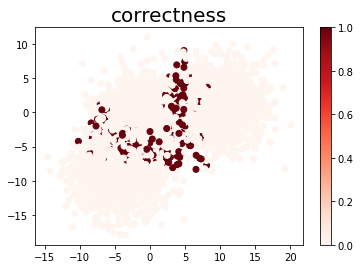

Epoch 00082: early stopping                           
Best validation loss of epoch:                        
0.1718585193157196                                    
Epoch 00111: early stopping                                                     
Best validation loss of epoch:                                                  
0.16842132806777954                                                             
Epoch 00084: early stopping                                                      
Best validation loss of epoch:                                                   
0.1682792603969574                                                               
Epoch 00073: early stopping                                                      
Best validation loss of epoch:                                                  
0.1670764833688736                                                              
Epoch 00111: early stopping                                                     
Best validation loss 

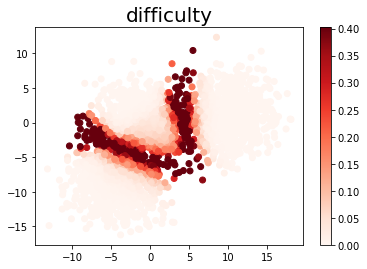

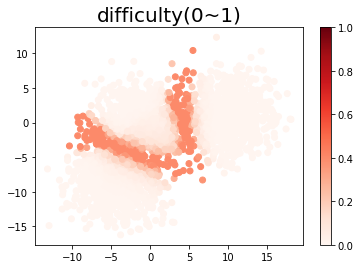

time per fold: 0:03:54.400958 second

fold: [1, 2, 3, 4, 0]
2    1640
1    1591
0    1569
Name: label, dtype: int64
Epoch 00107: early stopping                          
Best validation loss of epoch:                       
0.19235917925834656                                  
Epoch 00099: early stopping                                                     
Best validation loss of epoch:                                                  
0.19011196494102478                                                             
Epoch 00126: early stopping                                                     
Best validation loss of epoch:                                                  
0.1955738216638565                                                              
Epoch 00058: early stopping                                                     
Best validation loss of epoch:                                                  
0.19928953051567078                                                       

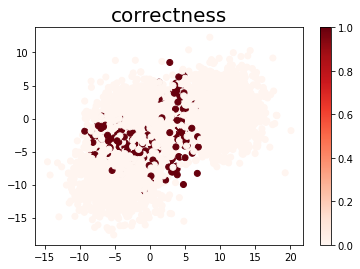

Epoch 00124: early stopping                           
Best validation loss of epoch:                        
0.16528064012527466                                   
Epoch 00103: early stopping                                                      
Best validation loss of epoch:                                                   
0.1663132756948471                                                               
Epoch 00071: early stopping                                                      
Best validation loss of epoch:                                                   
0.22269460558891296                                                              
Epoch 00051: early stopping                                                      
Best validation loss of epoch:                                                   
0.23956850171089172                                                              
Epoch 00128: early stopping                                                      
Best validation

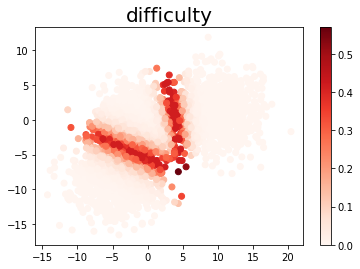

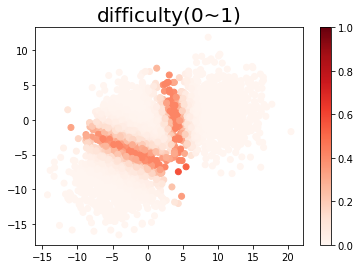

time per fold: 0:04:23.129146 second

fold: [2, 3, 4, 0, 1]
2    1613
1    1604
0    1583
Name: label, dtype: int64
Epoch 00085: early stopping                          
Best validation loss of epoch:                       
0.16826777160167694                                  
Epoch 00095: early stopping                                                     
Best validation loss of epoch:                                                  
0.17826206982135773                                                             
Epoch 00096: early stopping                                                     
Best validation loss of epoch:                                                  
0.16886070370674133                                                             
Epoch 00077: early stopping                                                     
Best validation loss of epoch:                                                  
0.16875822842121124                                                       

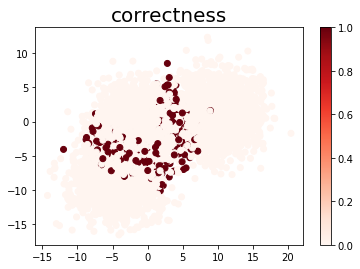

Epoch 00187: early stopping                           
Best validation loss of epoch:                        
0.1745876967906952                                    
Epoch 00064: early stopping                                                     
Best validation loss of epoch:                                                  
0.216908797621727                                                               
Epoch 00055: early stopping                                                     
Best validation loss of epoch:                                                  
0.23257526755332947                                                             
Epoch 00116: early stopping                                                     
Best validation loss of epoch:                                                  
0.23450323939323425                                                             
Epoch 00114: early stopping                                                     
Best validation loss of e

2023-02-15 09:44:37.576765: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch 00087: early stopping                                                     
Best validation loss of epoch:                                                  
0.20041915774345398                                                             
Epoch 00186: early stopping                                                     
Best validation loss of epoch:                                                  
0.1768932044506073                                                              
100%|██████████| 10/10 [03:31<00:00, 21.16s/trial, best loss: 0.1745876967906952]
best: {'activation': 1, 'batch_size': 1, 'hidden_layer_sizes': 20, 'learnRate': 0}
best_params_B: {'activation': 'tanh', 'batch_size': 64, 'hidden_layer_sizes': (5, 5, 5), 'learnRate': 0.01}


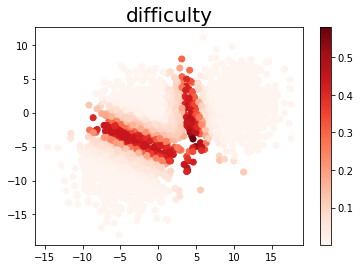

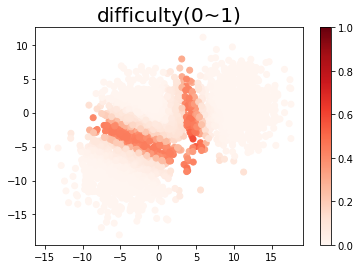

time per fold: 0:04:49.896463 second

fold: [3, 4, 0, 1, 2]
0    1642
2    1584
1    1574
Name: label, dtype: int64
Epoch 00055: early stopping                          
Best validation loss of epoch:                       
0.17785051465034485                                  
Epoch 00086: early stopping                                                     
Best validation loss of epoch:                                                  
0.2565549910068512                                                              
Epoch 00099: early stopping                                                     
Best validation loss of epoch:                                                  
0.17349252104759216                                                             
 60%|██████    | 3/5 [01:12<00:49, 24.87s/trial, best loss: 0.17349252104759216]

2023-02-15 09:46:44.004762: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch 00168: early stopping                                                     
Best validation loss of epoch:                                                  
0.17078182101249695                                                             
Epoch 00053: early stopping                                                     
Best validation loss of epoch:                                                  
0.26906830072402954                                                             
100%|██████████| 5/5 [01:47<00:00, 21.58s/trial, best loss: 0.17078182101249695]
best: {'activation': 1, 'batch_size': 2, 'hidden_layer_sizes': 24, 'learnRate': 1}
best_params_A: {'activation': 'tanh', 'batch_size': 128, 'hidden_layer_sizes': (5, 10, 5), 'learnRate': 0.03}
1    1628
0    1591
2    1581
Name: label, dtype: int64
number of incorrect predictions: 360
1    4440
0     360
Name: correctness, dtype: int64


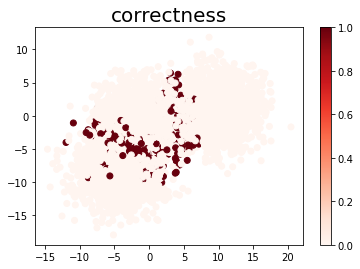

Epoch 00066: early stopping                           
Best validation loss of epoch:                        
0.18134824931621552                                   
Epoch 00054: early stopping                                                      
Best validation loss of epoch:                                                   
0.17746083438396454                                                              
Epoch 00145: early stopping                                                      
Best validation loss of epoch:                                                   
0.2282884120941162                                                               
Epoch 00088: early stopping                                                      
Best validation loss of epoch:                                                   
0.18223688006401062                                                              
Epoch 00076: early stopping                                                      
Best validation

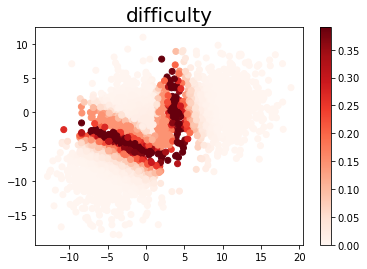

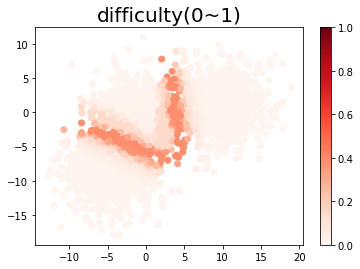

time per fold: 0:06:23.960799 second

fold: [4, 0, 1, 2, 3]
0    1615
1    1603
2    1582
Name: label, dtype: int64
Epoch 00096: early stopping                          
Best validation loss of epoch:                       
0.18288245797157288                                  
Epoch 00087: early stopping                                                     
Best validation loss of epoch:                                                  
0.18592241406440735                                                             
Epoch 00117: early stopping                                                     
Best validation loss of epoch:                                                  
0.18319420516490936                                                             
Epoch 00054: early stopping                                                     
Best validation loss of epoch:                                                  
0.17978721857070923                                                       

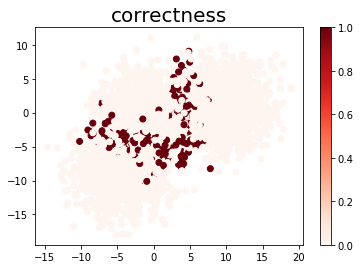

Epoch 00112: early stopping                           
Best validation loss of epoch:                        
0.22133199870586395                                   
Epoch 00068: early stopping                                                      
Best validation loss of epoch:                                                   
0.1912158727645874                                                               
Epoch 00088: early stopping                                                      
Best validation loss of epoch:                                                  
0.18806764483451843                                                             
Epoch 00137: early stopping                                                      
Best validation loss of epoch:                                                   
0.2006506621837616                                                               
Epoch 00060: early stopping                                                      
Best validation l

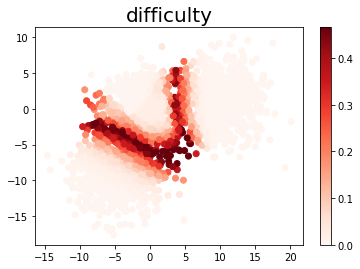

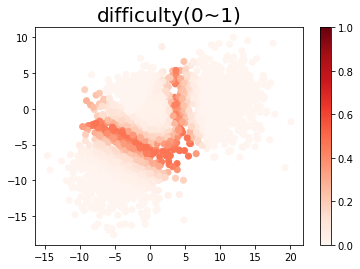

time per fold: 0:05:52.332120 second
Overall time per fold: 0:25:23.724860 second


In [ ]:
Final_data_save = []
Final_difficulty_save = []
sum_number_incorrect = []

overall_start_time = datetime.now()
for i in range(len(fold_order)):
    start_time = datetime.now()
    folds = fold_order[i]
    print('\nfold:',folds)
    difficulty_data_for_model_B,difficulty = CDdm(three_nd_X,three_nd_y,folds)
    Final_data_save.append(difficulty_data_for_model_B)
    Final_difficulty_save.append(difficulty)
    end_time = datetime.now()
    print("time per fold:",end_time - start_time,'second')

overall_end_time = datetime.now()
print("Overall time per fold:",overall_end_time - overall_start_time,'second')

In [ ]:
print(sum_number_incorrect)
print(sum(sum_number_incorrect))

[352, 339, 363, 360, 356]
1770


In [ ]:
dataframe_temp = Final_data_save
for i in range(len(fold_order)):
    dataframe_temp[i]['difficulty'] = Final_difficulty_save[i]

In [ ]:
temp_df= pd.DataFrame(np.row_stack([dataframe_temp[0], dataframe_temp[1], dataframe_temp[2], dataframe_temp[3], dataframe_temp[4]]),
                               columns=['x1', 'x2', 'label','difficulty'])

In [ ]:
writer = pd.ExcelWriter(file_name)
temp_df.to_excel(writer,header=True,index=False)
writer.save()

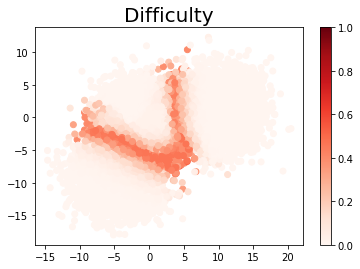

In [ ]:
# Case difficulty visualization
plot = plt.scatter(temp_df['x1'], temp_df['x2'], c=temp_df['difficulty'],cmap='Reds', vmin=0, vmax=1)
plt.colorbar(plot)
plt.title("Difficulty",fontsize=20)
plt.show()